In [118]:
import os
import sys
import argparse
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm

import matplotlib.pyplot as plt 


sys.path.append('../')
from torchlib.datasets.fersynthetic  import SyntheticFaceDataset, SecuencialSyntheticFaceDataset
from torchlib.datasets.factory  import FactoryDataset
from torchlib.datasets.fer import FERClassicDataset, FERDarkClassicDataset


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [119]:
path = os.path.expanduser( "~/.datasets/" )
namedataset = 'ck'
train=True  

dataset = FERClassicDataset(os.path.join( path, namedataset)  , namedataset, idenselect=[], train=train )
print(len(dataset))

327


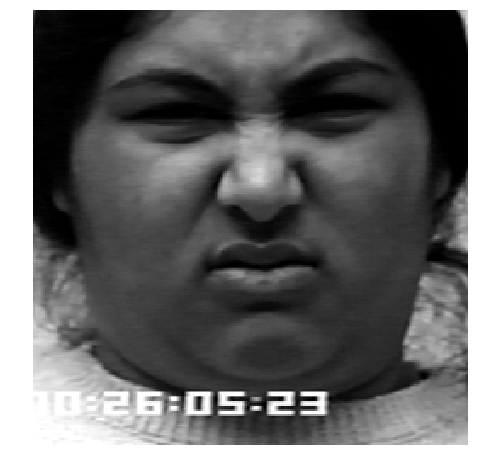

In [120]:

image, label = dataset[0]

plt.figure( figsize=(8,8) )
plt.imshow( image,  cmap='gray')
plt.axis('off')
plt.show()


(128, 128)
(128, 128)
(128, 128)
0.0 219.0


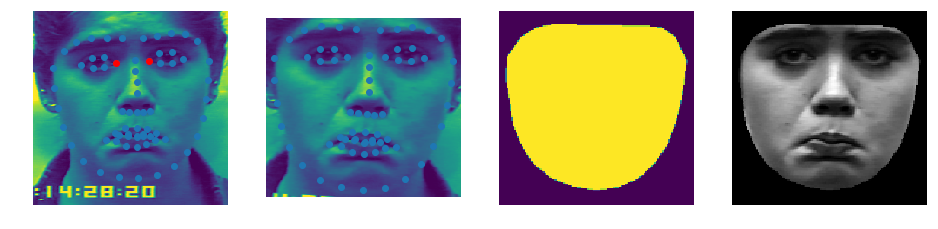

In [121]:
import math
from pytvision.transforms import functional as F

def getmask( x, p ):
    mask = np.zeros( x.shape[:2] )
    p = [  [[int(e[0]),int(e[1]) ]]  for e in p ]
    hull = cv2.convexHull( np.array(p),  False  )
    cv2.fillPoly(mask, [hull], 1)   
    return mask

def param2theta(mat_r, w, h):
    H = np.concatenate( (mat_r,[[0,0,1]]),axis=0 )      
    param = H #np.linalg.inv(H)
    theta = np.zeros([2,3])
    theta[0,0] = param[0,0]
    theta[0,1] = param[0,1]*h/w
    theta[0,2] = param[0,2]*2/w + param[0,0] + param[0,1] - 1
    theta[1,0] = param[1,0]*w/h
    theta[1,1] = param[1,1]
    theta[1,2] = param[1,2]*2/h + param[1,0] + param[1,1] - 1
    return theta

def angle2mat( fi ):
    "To convert angle to rotation matrix"
    rx = fi[0]; ry = fi[1]; rz = fi[2];
    sx = np.sin(rx); cx = np.cos(rx)
    sy = np.sin(ry); cy = np.cos(ry)
    sz = np.sin(rz); cz = np.cos(rz)
    Rx = np.array([[ 1,   0,  0], [ 0, cx, -sx], [  0, sx, cx]])
    Ry = np.array([[cy,   0, sy], [ 0,  1,   0], [-sy,  0, cy]]) 
    Rz = np.array([[cz, -sz,  0], [sz, cz,   0], [  0,  0,  1]])
    return np.dot(Rz,np.dot(Ry,Rx))

def boundingbox(box):
    "Estimate boundingbox"
    xmin = np.min(box[:,0]); ymin = np.min(box[:,1])
    xmax = np.max(box[:,0]); ymax = np.max(box[:,1])
    bbox = np.array([[xmin, ymin],[xmax, ymax]])
    return bbox

def resize( image, height=128,  width=128, interpolate_mode=cv2.INTER_LANCZOS4 ):
    return F.resize_image(image, 
        height=height, width=width, 
        resize_mode='square', 
        padding_mode=cv2.BORDER_CONSTANT,
        interpolate_mode=interpolate_mode, 
        )

def adjust( image, plm  ):
    
    mu = plm.mean(axis=0)
    plm_c = plm - mu

    p1 = [ *plm_c[39,:], 1 ] 
    p2 = [ *plm_c[42,:], 1 ] 
    
    l = np.cross(p1, p2)
    th =  math.atan2( l[1]/l[2], l[0]/l[2] )

    #print(90 - th* 180 / math.pi)
    d = ( (p1[0] - p2[0] )**2 + (p1[1] - p2[1] )**2 ) ** 0.5
    #print(d*0.2)
    
    ang = 90 - th* 180 / math.pi
    imsize = image.shape     

    matR = cv2.getRotationMatrix2D( (imsize[1]//2, imsize[0]//2) , -ang ,1 ) 
    H = param2theta(matR, imsize[1], imsize[0]  )   
    image_rot = cv2.warpAffine(image, matR, (imsize[1], imsize[0]))
    plm_rot = np.dot( H, np.concatenate((plm_c,np.ones([plm_c.shape[0],1])),axis=1).T )   
    plm_rot = plm_rot.T
    plm_rot = plm_rot + mu
    
    bbox = boundingbox( plm_rot )
    
    br = d*0.2
    bbox[0,0] = bbox[0,0] - br if bbox[0,0] - br > 0 else 0    
    bbox[0,1] = bbox[0,1] - br if bbox[0,1] - br > 0 else 0
    bbox[1,0] = bbox[1,0] + br if bbox[1,0] + br < imsize[0] else imsize[1]
    bbox[1,1] = bbox[1,1] + br if bbox[1,1] + br < imsize[1] else imsize[0]
        
        
    image_rot = image_rot[  int(bbox[0,1]):int(bbox[1,1]), int(bbox[0,0]):int(bbox[1,0]) ]
    plm_rot[:,0] = plm_rot[:,0] - bbox[0,0]
    plm_rot[:,1] = plm_rot[:,1] - bbox[0,1]
    
    return image_rot, plm_rot
 
i = 5
image, label = dataset[ i ]
plm = np.array(dataset.getladmarks()).reshape( -1, 2 )

image_rot, plm_rot = adjust( image, plm )
mask_rot = getmask( image_rot, plm_rot )
image_rot_t = image_rot
# print( image_rot.shape )
# print( plm_rot.shape )
# print( mask_rot.shape )

image_rot  = resize( image_rot, height=128,  width=128, interpolate_mode=cv2.INTER_LANCZOS4 )[:,:,0]
mask_rot   = resize( mask_rot , height=128,  width=128, interpolate_mode=cv2.INTER_LINEAR )[:,:,0]
image_mask = (image_rot * mask_rot)

print(image_rot.shape)
print(mask_rot.shape)
print(image_mask.shape)
print(image_mask.min(), image_mask.max())

plt.figure( figsize=(16,8) )
plt.subplot(141)
plt.imshow( image, cmap='gray' )
plt.plot(plm[:,0],plm[:,1] ,'o')
plt.plot(plm[39,0],plm[39,1] ,'ro')
plt.plot(plm[42,0],plm[42,1] ,'ro')
plt.axis('off')
plt.subplot(142)
plt.imshow( image_rot_t, cmap='gray' )
plt.plot(plm_rot[:,0],plm_rot[:,1] ,'o')
plt.axis('off')
plt.subplot(143)
plt.imshow( mask_rot )
plt.axis('off')
plt.subplot(144)
plt.imshow( image_mask, cmap='gray' )
plt.axis('off')
plt.show()
    

In [62]:
path = os.path.expanduser( "~/.datasets/" )
namedataset = 'ck'
train=True  

dataset = FERDarkClassicDataset(os.path.join( path, namedataset)  , namedataset, idenselect=[], train=train )
print(len(dataset))



327


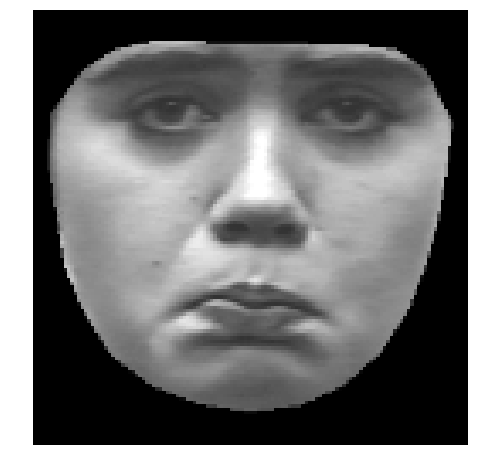

In [63]:
image, label = dataset[5]

plt.figure( figsize=(8,8) )
plt.imshow( image,  cmap='gray')
plt.axis('off')
plt.show()


In [64]:

pathnamedata  = '~/.datasets'
pathnameback  = '~/.datasets/coco'
imsize        = 128

data=FactoryDataset.factory(
    pathname=pathnamedata, 
    name=FactoryDataset.ckdark, 
    subset=FactoryDataset.training, 
    download=True 
    )

dataset = SyntheticFaceDataset(
    data,
    pathnameback,
    generate='image_and_mask',
    iluminate=True, angle=45, translation=0.2, warp=0.1, factor=0.2,
)

print( len(dataset) )

327


(148, 148, 3)
(148, 148, 2) 0.0 1.0
[ 0.94009795  0.30467697 -0.18068897 -0.34783242  0.96599491 -0.34297219]


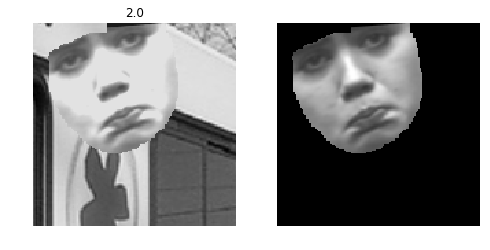

In [70]:
image_org, image, mask, meta = dataset[ 5 ]   
label = meta[0]
theta = meta[1:]
#x_org, x_img, y_mask, y_lab

# print(idx)
print(image.shape)
print(mask.shape, mask.min(), mask.max() )
print(theta)


mask = mask[:,:,1]

plt.figure( figsize=(8,8) )
plt.subplot(121)
plt.imshow(image)
plt.title( label )
plt.axis('off')
plt.subplot(122)
plt.imshow(image_org)
plt.axis('off')

plt.show()


(-13.439097721505602, 255.5, 255.5, -23.262695521997674)

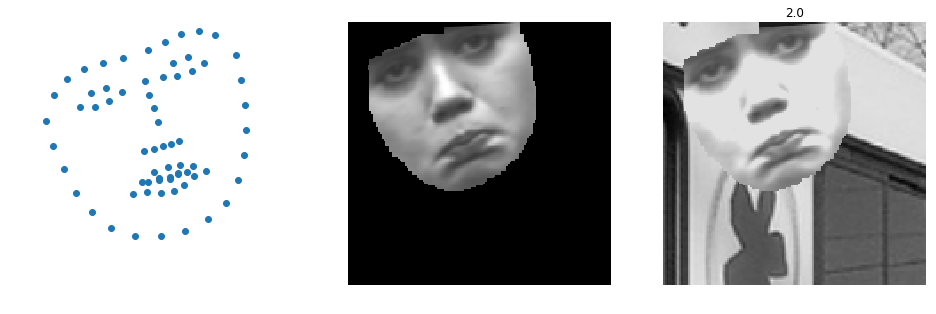

In [116]:
H = theta.reshape( 2,3 ) 
# plm = np.array(dataset.data.getladmarks()).reshape( -1, 2 )
plm = plm_rot
# print(plm)

mu = plm.mean(axis=0)
plm_c = plm - mu
plm_rot_n = np.dot( H, np.concatenate((plm_c,np.ones([plm_c.shape[0],1])),axis=1).T )   
plm_rot_n = plm_rot_n.T
plm_rot_n = plm_rot_n + mu

plt.figure( figsize=(16,12) )
plt.subplot(133)
plt.imshow(image)
plt.title( label )
plt.axis('off')
plt.subplot(132)
plt.imshow(image_org)
plt.axis('off')
plt.subplot(131)
plt.imshow( np.ones((256,256,3)) )
plt.plot(plm_rot_n[:,0],plm_rot_n[:,1] ,'o')
plt.axis('off')




## Pytorch Loader 

In [3]:
sys.path.append('../')
from torch.utils.data import Dataset, DataLoader
from aug import get_transforms_aug, get_transforms_det

In [5]:

imsize=128
pathnamedata = '~/.datasets'
pathnameback = '~/.datasets/coco'

data=FactoryDataset.factory(
    pathname=pathnamedata, 
    name=FactoryDataset.ckdark,
    subset=FactoryDataset.training, 
    download=True 
    )

dataset = SecuencialSyntheticFaceDataset(
    data,
    pathnameback,
    generate='image_and_mask',
    iluminate=True, angle=45, translation=0.2, warp=0.2, factor=0.2,
    transform_data=get_transforms_aug( imsize ),
    transform_image=get_transforms_det( imsize ),
)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4 )
print( len(dataset) )

358


torch.Size([4, 3, 128, 128]) torch.Size([4, 3, 128, 128]) torch.Size([4, 2, 128, 128]) torch.Size([4, 7])
tensor(0.) tensor(0.9961)
tensor(0.0118) tensor(0.9725)
tensor(0.) tensor(1.)


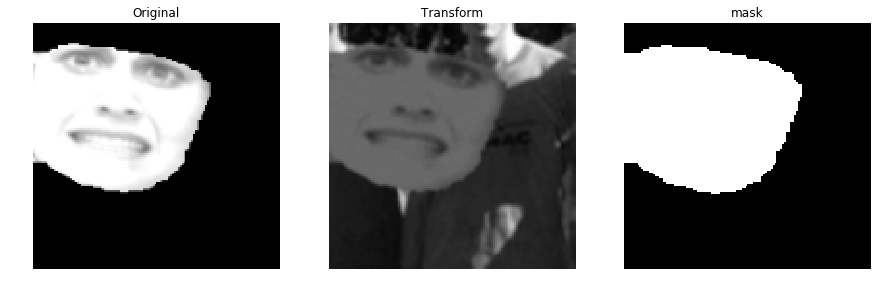

torch.Size([4, 3, 128, 128]) torch.Size([4, 3, 128, 128]) torch.Size([4, 2, 128, 128]) torch.Size([4, 7])
tensor(0.) tensor(0.9922)
tensor(0.) tensor(0.7804)
tensor(0.) tensor(1.)


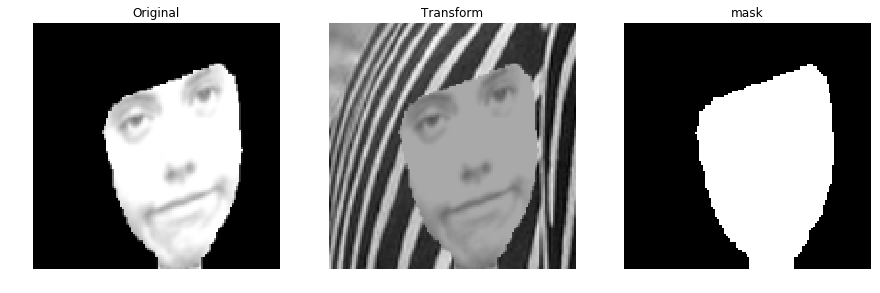

torch.Size([4, 3, 128, 128]) torch.Size([4, 3, 128, 128]) torch.Size([4, 2, 128, 128]) torch.Size([4, 7])
tensor(0.) tensor(0.9961)
tensor(0.) tensor(0.4078)
tensor(0.) tensor(1.)


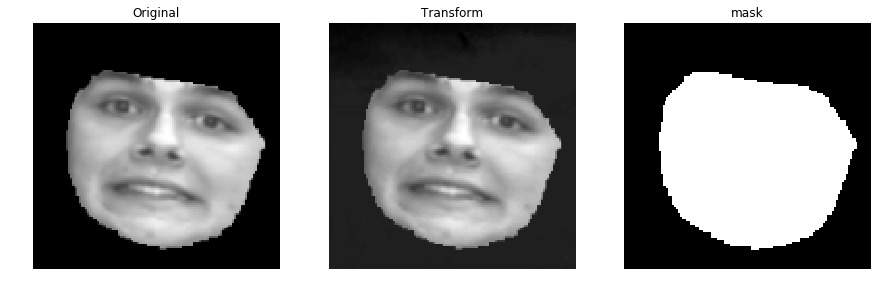

torch.Size([4, 3, 128, 128]) torch.Size([4, 3, 128, 128]) torch.Size([4, 2, 128, 128]) torch.Size([4, 7])
tensor(0.) tensor(0.9961)
tensor(0.) tensor(0.6745)
tensor(0.) tensor(1.)


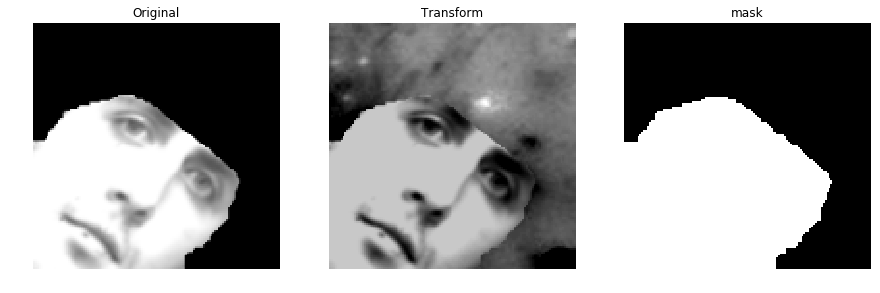

torch.Size([4, 3, 128, 128]) torch.Size([4, 3, 128, 128]) torch.Size([4, 2, 128, 128]) torch.Size([4, 7])
tensor(0.) tensor(0.9961)
tensor(0.0039) tensor(0.9882)
tensor(0.) tensor(1.)


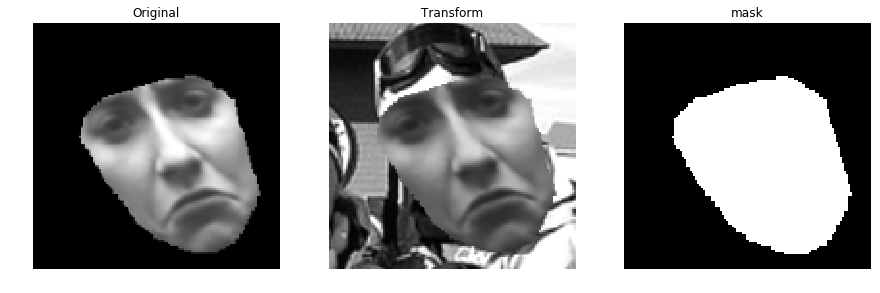

torch.Size([4, 3, 128, 128]) torch.Size([4, 3, 128, 128]) torch.Size([4, 2, 128, 128]) torch.Size([4, 7])
tensor(0.) tensor(1.)
tensor(0.1294) tensor(0.8980)
tensor(0.) tensor(1.)


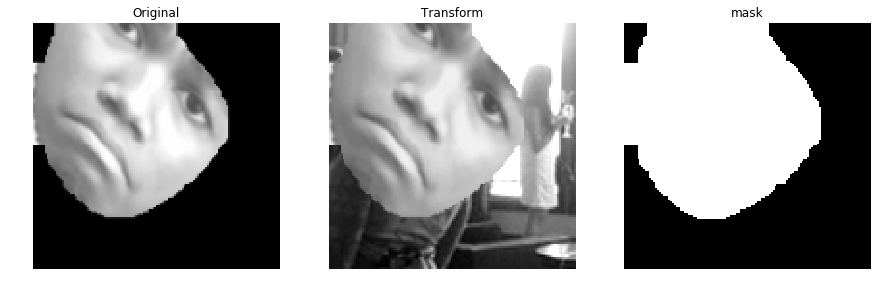

In [6]:
label_batched = []
for i_batch, (x_org, x_img, y_mask, meta ) in enumerate(dataloader):
    print(x_org.shape, x_img.shape, y_mask.shape, meta.shape)
    
    
    img_org = x_org[0,0,...]
    img_trf = x_img[0,0,...]
    mask    = y_mask[0,1,...]
    
    
    print(img_org.min(), img_org.max() )
    print(img_trf.min(), img_trf.max() )
    print(mask.min(), mask.max() )
    
    # observe 4th batch and stop.
                
    plt.figure( figsize=(15,15) )
    plt.subplot(131)
    plt.imshow(img_org,cmap='gray')
    plt.title('Original')
    plt.axis('off')
    plt.ioff()
    
    plt.subplot(132)
    plt.imshow(img_trf,cmap='gray')
    plt.title('Transform')
    plt.axis('off')
    plt.ioff()

    plt.subplot(133)
    plt.imshow(mask,cmap='gray')
    plt.title('mask')
    plt.axis('off')
    plt.ioff()        
    plt.show()   
        
    if i_batch == 5:
        break